# This is an example of querying images from the database

## Import Essential Libraries

In [1]:
import tensorflow as tf

import random

import numpy as np

import h5py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.util import random_noise

from model import VGGNet

## Load Dataset

In [2]:
datasets = h5py.File('features.h5', 'r')
features = datasets['features'][:]
image_ids = datasets['image_ids'][:]
datasets.close()

## Load Model

In [3]:
model = VGGNet()

1/1 [==============================] - 5s 5s/step


## Query Images

### Querying without any modification

#### Get a image to test without any modification

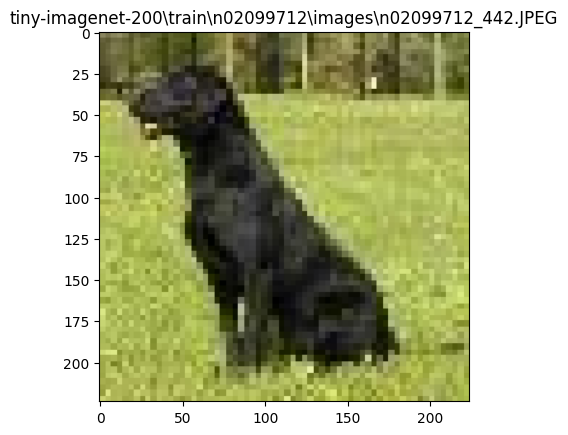

In [4]:
query_img_path = image_ids.astype(str)[random.randint(0, len(image_ids))]
query_img = tf.keras.utils.load_img(query_img_path, target_size=(model.input_shape[0], model.input_shape[1]))
query_img = tf.keras.utils.img_to_array(query_img)

plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

#### Query the image from all of the images in the dataset

In [5]:
query_feature = model.extract_feature(query_img)
scores = np.dot(query_feature, features.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

1/1 [==============================] - 0s 23ms/step


In [7]:
imlist = [image_ids.astype(str)[index] for i, index in enumerate(rank_ID[0:10])]
print("top %d images in order are:" % 10, '\n' + '\n'.join(imlist))

top 10 images in order are: 
tiny-imagenet-200\train\n02099712\images\n02099712_442.JPEG
tiny-imagenet-200\train\n02106662\images\n02106662_0.JPEG
tiny-imagenet-200\train\n02113799\images\n02113799_400.JPEG
tiny-imagenet-200\train\n02099712\images\n02099712_43.JPEG
tiny-imagenet-200\train\n02481823\images\n02481823_203.JPEG
tiny-imagenet-200\train\n02099712\images\n02099712_486.JPEG
tiny-imagenet-200\train\n02364673\images\n02364673_486.JPEG
tiny-imagenet-200\train\n02099712\images\n02099712_73.JPEG
tiny-imagenet-200\train\n02106662\images\n02106662_334.JPEG
tiny-imagenet-200\train\n02113799\images\n02113799_409.JPEG


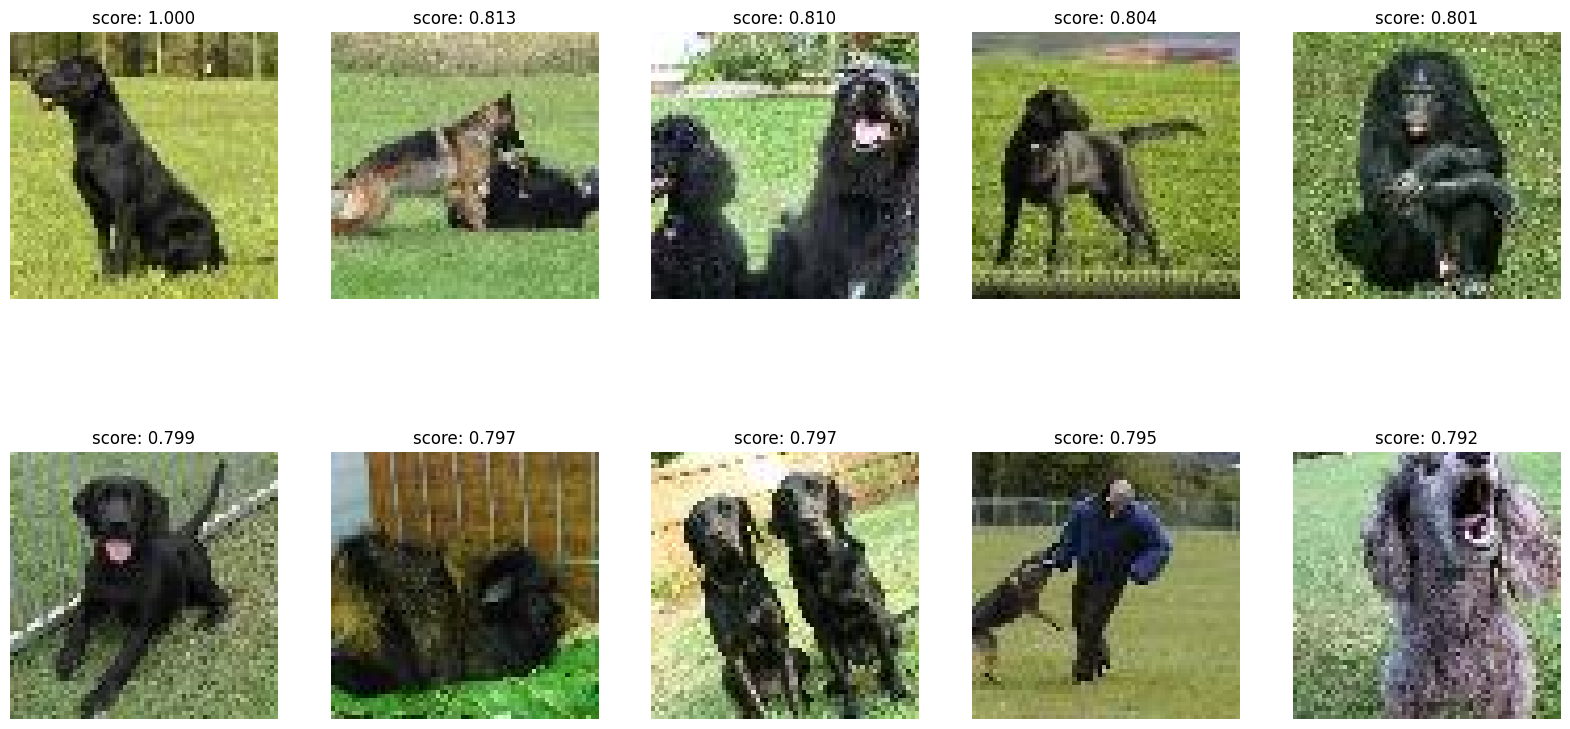

In [8]:
# draw top 10 images
plt.figure(figsize=(20, 10))
for i, im in enumerate(imlist):
    image = mpimg.imread(im)
    plt.subplot(2, 5, i+1)
    plt.title(f'score: {rank_score[i]:.3f}')
    plt.imshow(image)
    plt.axis('off')

### Querying with Gaussian noise

#### Get a image to test randomly with Gaussian noise

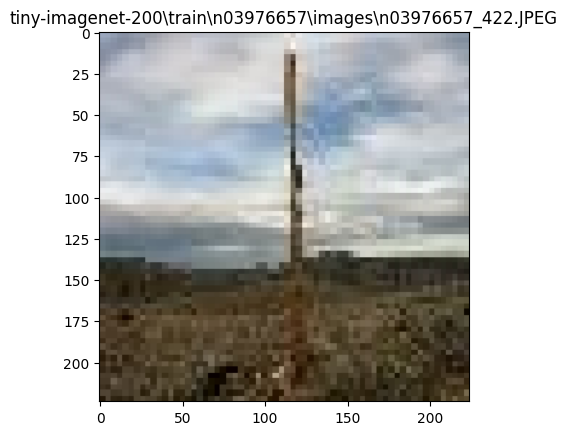

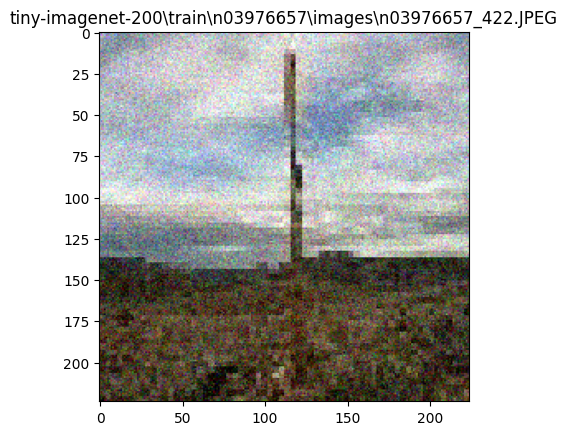

In [9]:
query_img_path = image_ids.astype(str)[random.randint(0, len(image_ids))]
query_img = tf.keras.utils.load_img(query_img_path, target_size=(model.input_shape[0], model.input_shape[1]))
query_img = tf.keras.utils.img_to_array(query_img)

plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

# Gaussian noise
query_img = random_noise(query_img / 255, mode='gaussian', clip=True)
query_img = np.array(query_img * 255, dtype=np.uint8)

plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

#### Query the image from all of the images in the dataset

In [10]:
query_feature = model.extract_feature(query_img)
scores = np.dot(query_feature, features.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

1/1 [==============================] - 0s 17ms/step


In [11]:
imlist = [image_ids.astype(str)[index] for i, index in enumerate(rank_ID[0:10])]
print("top %d images in order are:" % 10, '\n' + '\n'.join(imlist))

top 10 images in order are: 
tiny-imagenet-200\train\n03976657\images\n03976657_422.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_412.JPEG
tiny-imagenet-200\train\n03355925\images\n03355925_66.JPEG
tiny-imagenet-200\train\n09193705\images\n09193705_376.JPEG
tiny-imagenet-200\train\n03837869\images\n03837869_374.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_116.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_423.JPEG
tiny-imagenet-200\train\n03837869\images\n03837869_88.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_244.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_231.JPEG


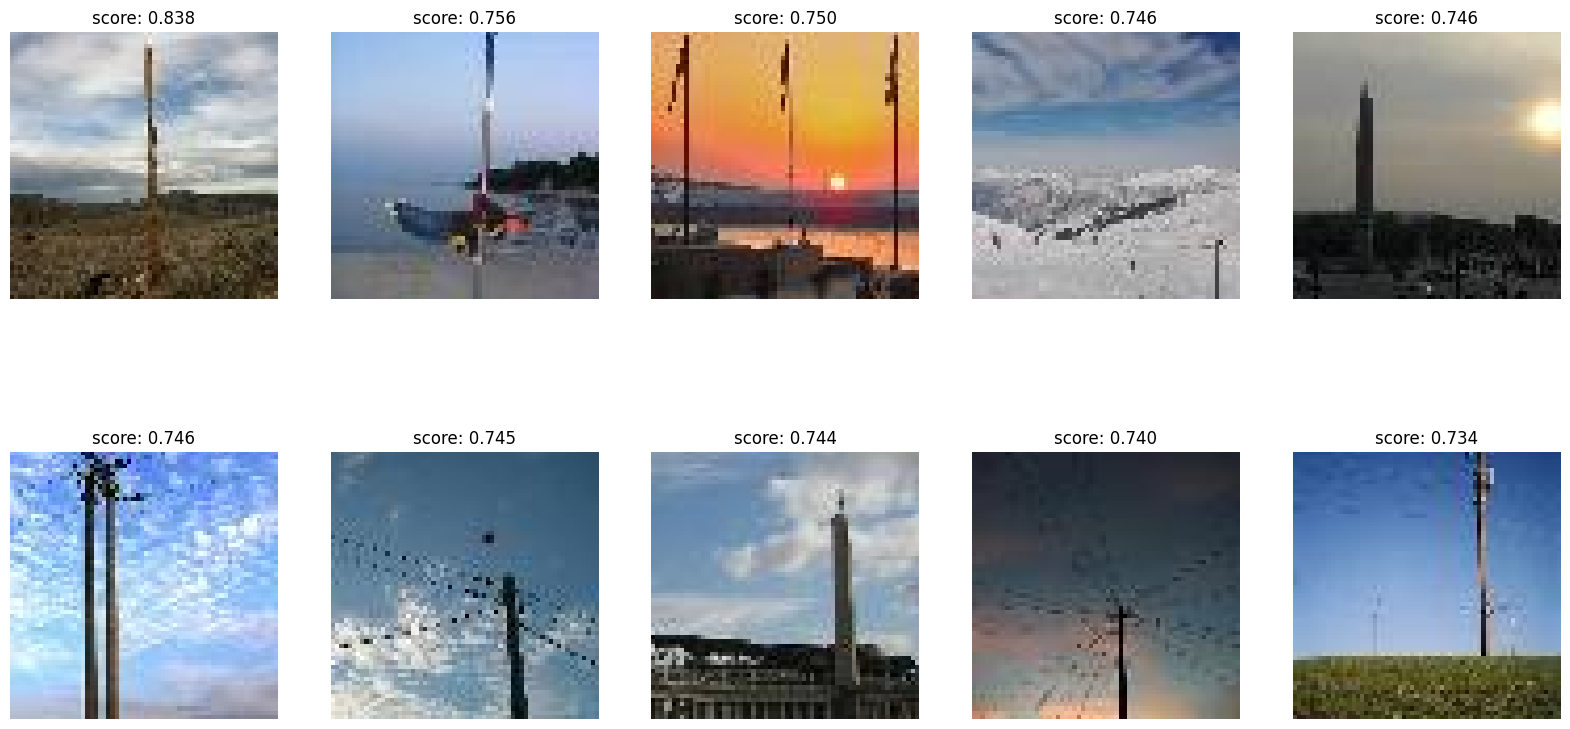

In [12]:
# draw top 10 images
plt.figure(figsize=(20, 10))
for i, im in enumerate(imlist):
    image = mpimg.imread(im)
    plt.subplot(2, 5, i+1)
    plt.title(f'score: {rank_score[i]:.3f}')
    plt.imshow(image)
    plt.axis('off')

### Use clustering to reduce the number of images to be queried

In [13]:
import pandas as pd
from sklearn.cluster import KMeans

#### Cluster the images in the dataset

I'm going to use K-means clustering with 10 clusters.

In [14]:
X = features
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto', verbose=2).fit(X)

Initialization complete
Iteration 0, inertia 58912.30078125.
Iteration 1, inertia 34574.10546875.
Iteration 2, inertia 34004.10546875.
Iteration 3, inertia 33800.2578125.
Iteration 4, inertia 33723.46484375.
Iteration 5, inertia 33693.109375.
Iteration 6, inertia 33677.20703125.
Iteration 7, inertia 33666.23046875.
Iteration 8, inertia 33657.69140625.
Iteration 9, inertia 33650.859375.
Iteration 10, inertia 33644.97265625.
Iteration 11, inertia 33639.22265625.
Iteration 12, inertia 33633.515625.
Iteration 13, inertia 33627.52734375.
Iteration 14, inertia 33621.24609375.
Iteration 15, inertia 33614.5390625.
Iteration 16, inertia 33607.69140625.
Iteration 17, inertia 33600.96875.
Iteration 18, inertia 33594.82421875.
Iteration 19, inertia 33589.44140625.
Iteration 20, inertia 33583.89453125.
Iteration 21, inertia 33578.44140625.
Iteration 22, inertia 33573.21875.
Iteration 23, inertia 33568.46875.
Iteration 24, inertia 33564.16796875.
Iteration 25, inertia 33560.21484375.
Iteration 26, i

In [15]:
# K = range(1, 20)
# KM = [KMeans(n_clusters=k, random_state=0).fit(X) for k in K]

In [16]:
# plt.plot(K, [km.inertia_ for km in KM], 'bx-')
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [17]:
# from sklearn.metrics import silhouette_score
# plt.plot(K, [silhouette_score(X, km.labels_) for km in KM[1:]], 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.title('The Silhouette Method showing the optimal k')
# plt.show()

In [18]:
kmeans.labels_

array([8, 1, 6, ..., 5, 2, 7])

In [19]:
predict = kmeans.predict(query_feature.reshape(1, -1))
predict

array([2])

In [20]:
df = pd.DataFrame({'image_id': image_ids.astype(str), 'cluster_id': kmeans.labels_})
df.head()

,image_id,cluster_id
0,tiny-imagenet-200\train\n03255030\images\n0325...,8
1,tiny-imagenet-200\train\n01443537\images\n0144...,1
2,tiny-imagenet-200\train\n02410509\images\n0241...,6
3,tiny-imagenet-200\train\n04259630\images\n0425...,2
4,tiny-imagenet-200\train\n01443537\images\n0144...,7


In [21]:
df[df['cluster_id'] == predict[0]].head()

,image_id,cluster_id
3,tiny-imagenet-200\train\n04259630\images\n0425...,2
23,tiny-imagenet-200\train\n03255030\images\n0325...,2
26,tiny-imagenet-200\train\n03255030\images\n0325...,2
33,tiny-imagenet-200\train\n03255030\images\n0325...,2
37,tiny-imagenet-200\train\n03255030\images\n0325...,2


In [22]:
query = df[df['cluster_id'] == predict[0]].index
# get fetures item by index
features[query]

array([[0.        , 0.        , 0.02564568, ..., 0.        , 0.01526102,
        0.        ],
       [0.10391042, 0.        , 0.05666847, ..., 0.        , 0.00849537,
        0.02722716],
       [0.0312769 , 0.        , 0.08351074, ..., 0.        , 0.0252508 ,
        0.        ],
       ...,
       [0.03917841, 0.        , 0.09002837, ..., 0.        , 0.00339027,
        0.        ],
       [0.        , 0.        , 0.0018531 , ..., 0.        , 0.09845284,
        0.04976311],
       [0.00573636, 0.        , 0.00591555, ..., 0.        , 0.02954483,
        0.        ]], dtype=float32)

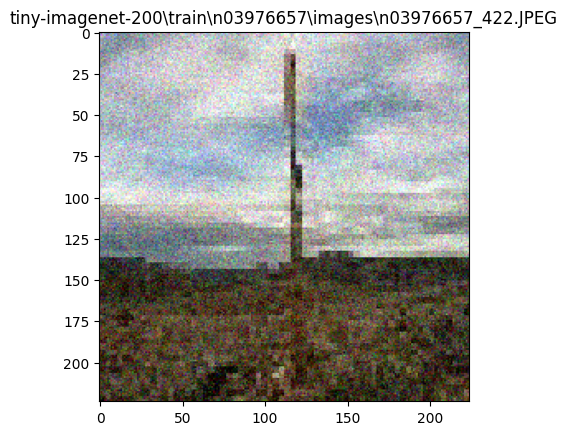

In [23]:
# query_img
plt.title(query_img_path)
plt.imshow(query_img.astype(int))
plt.show()

In [24]:
query_feature = model.extract_feature(query_img)
scores = np.dot(query_feature, features[query].T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

1/1 [==============================] - 0s 16ms/step


In [25]:
scores.shape

(6517,)

In [26]:
scores

array([0.50762355, 0.4900805 , 0.61930525, ..., 0.4381846 , 0.5678375 ,
       0.46716392], dtype=float32)

In [27]:
rank_ID

array([4709, 4702,  373, ..., 2414, 4453, 3109], dtype=int64)

In [28]:
rank_score

array([0.8381798 , 0.7564745 , 0.7503685 , ..., 0.33479223, 0.30975977,
       0.30722177], dtype=float32)

In [29]:
imlist = [image_ids.astype(str)[index] for i, index in enumerate(query[rank_ID[0:10]])]
print("top %d images in order are:" % 10, '\n' + '\n'.join(imlist))

top 10 images in order are: 
tiny-imagenet-200\train\n03976657\images\n03976657_422.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_412.JPEG
tiny-imagenet-200\train\n03355925\images\n03355925_66.JPEG
tiny-imagenet-200\train\n03837869\images\n03837869_374.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_116.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_423.JPEG
tiny-imagenet-200\train\n03837869\images\n03837869_88.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_244.JPEG
tiny-imagenet-200\train\n03976657\images\n03976657_231.JPEG
tiny-imagenet-200\train\n03837869\images\n03837869_129.JPEG


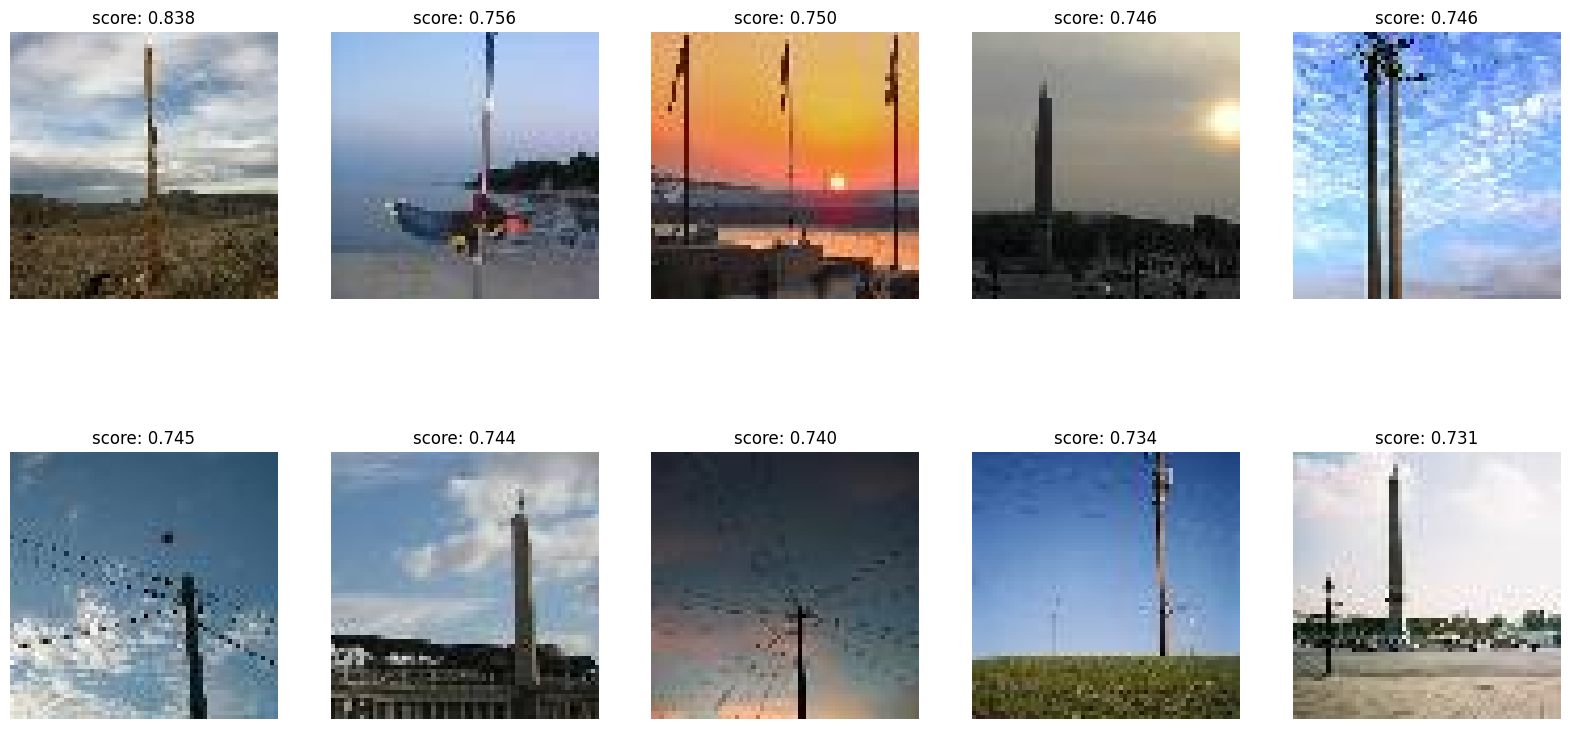

In [30]:
# draw top 10 images
plt.figure(figsize=(20, 10))
for i, im in enumerate(imlist):
    image = mpimg.imread(im)
    plt.subplot(2, 5, i+1)
    plt.title(f'score: {rank_score[i]:.3f}')
    plt.imshow(image)
    plt.axis('off')